## 4. Generate a bird's eye view of a lane

In [2]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

### 4.1 Camera Calibration

Essential to correct any camera distortion that can subtly affect accuracy when to any image transform. The distortion in every picture is minimal so, as expected, they are similar to the original ones.

In [65]:
def calibrate_camera():
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob('images/ex4/calibration/*.jpg')

    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (7,6), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return objpoints, imgpoints, ret, mtx, dist, rvecs, tvecs

In [66]:
def undistort_img(img, mtx, dist, name):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    dst = cv.undistort(img, mtx, dist, None, newcameramtx)

    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    cv.imwrite('images/ex4/' + name + '_undistorted.jpeg', dst)

    return cv.imread('images/ex4/' + name + '_undistorted.jpeg')

In [67]:
def display_undistorted(img, dst):

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Converting BGR to RGB
    dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB) # Converting BGR to RGB

    _, axs = plt.subplots(1, 2, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip([img,dst], axs):
        ax.imshow(img)

    axs[0].set_title('Original')
    axs[1].set_title('Undistorted')
    
    plt.show()

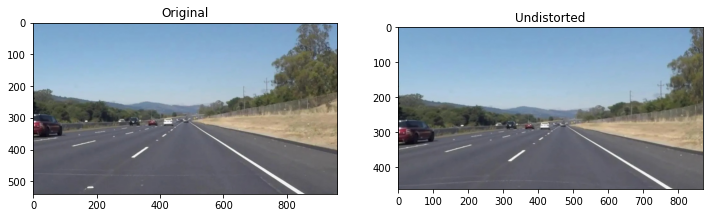

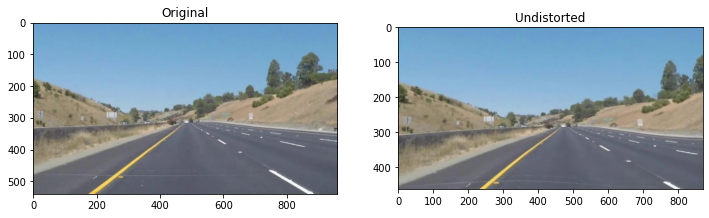

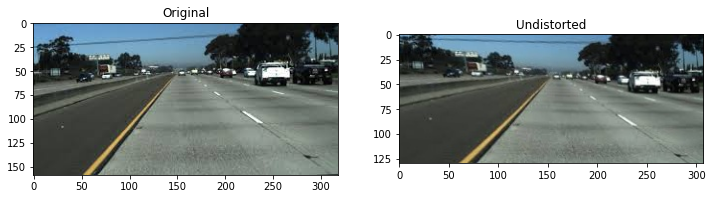

In [68]:
objpoints, imgpoints, ret, mtx, dist, rvecs, tvecs = calibrate_camera()
for lane in range(1,4):
    img = cv.imread('images/ex4/lane' + str(lane) + '.jpeg')
    dst = undistort_img(img, mtx, dist, 'lane' + str(lane))
    display_undistorted(img, dst)

#### Re-Projection Error
Re-projection error gives a good estimation of just how exact the found parameters are. The closer the re-projection error is to zero, the more accurate the parameters we found are.

In [69]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "Total error: {}".format(mean_error/len(objpoints)))

total error: 0.023686000375385676


### 4.2 Edge Detection & Segmentation


#### 4.2.1 Color Segmentation

We analyzed the colorspaces in the first picture to see which one (or each respective channel, more specifically) would highlight better the white/yellow lines: R in BGR, V in HSV, S in HSL, L in LUV, Y in YUV and L in LAB.

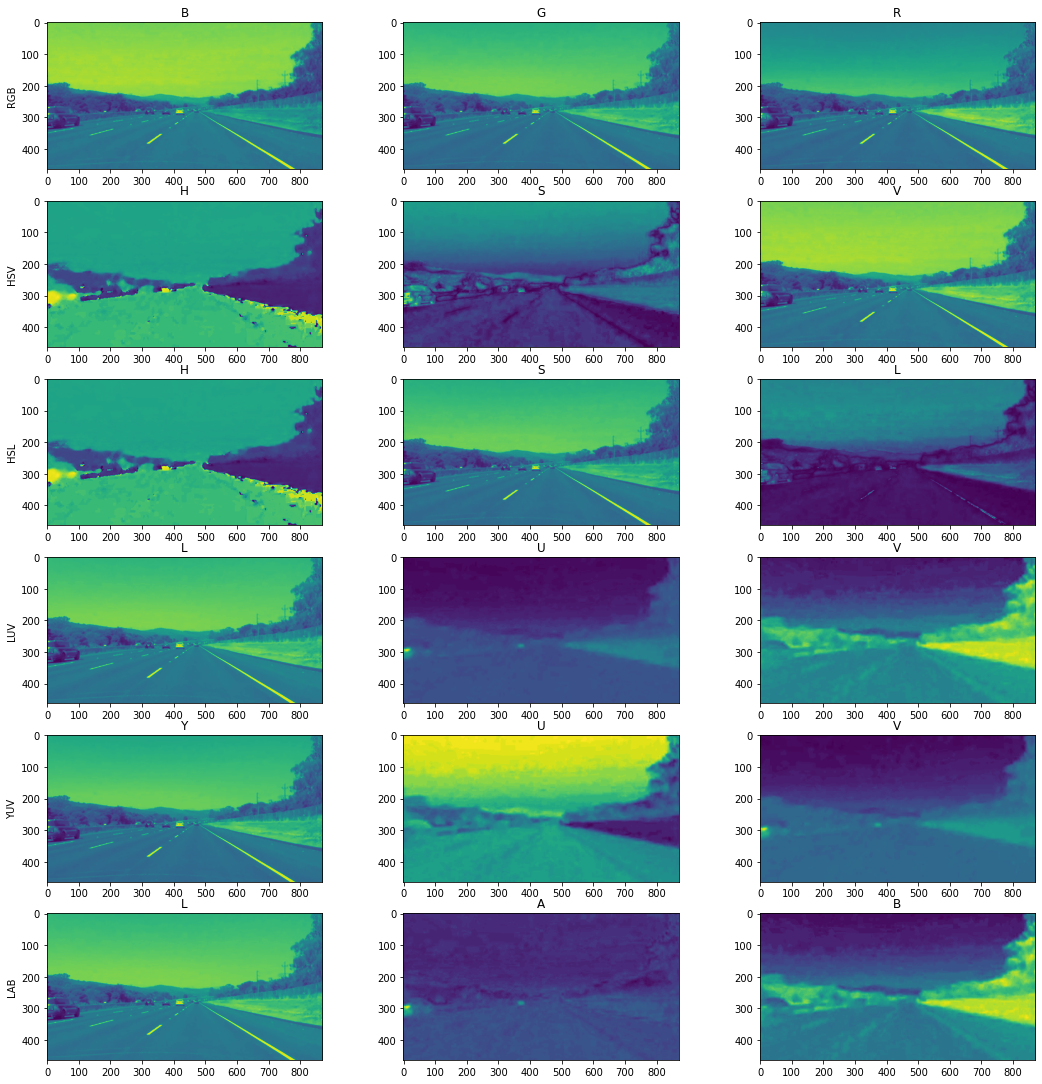

In [245]:
img = cv.imread('images/ex4/lane1_undistorted.jpeg')
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
hsl = cv.cvtColor(img, cv.COLOR_BGR2HLS)
luv = cv.cvtColor(img, cv.COLOR_BGR2LUV)
yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)

b1, g, r = cv.split(img)
h1,s1,v1 = cv.split(hsv)
h2,s2,l1 = cv.split(hsl)
l2,u1,v2 = cv.split(luv)
y,u2,v3 = cv.split(yuv)
l3,a,b2 = cv.split(lab)

channels = [b1, g, r, h1,s1,v1, h2,s2,l1, l2,u1,v2, y,u2,v3, l3,a,b2]
fig, axs = plt.subplots(6, 3, figsize=(15, 15))
axs = axs.flatten()
fig.tight_layout()

for img, ax in zip(channels, axs):
    ax.imshow(img)

axs[0].set_ylabel('BGR')
axs[0].set_title('B')
axs[1].set_title('G')
axs[2].set_title('R')

axs[3].set_ylabel('HSV')
axs[3].set_title('H')
axs[4].set_title('S')
axs[5].set_title('V')

axs[6].set_ylabel('HSL')
axs[6].set_title('H')
axs[7].set_title('S')
axs[8].set_title('L')

axs[9].set_ylabel('LUV')
axs[9].set_title('L')
axs[10].set_title('U')
axs[11].set_title('V')

axs[12].set_ylabel('YUV')
axs[12].set_title('Y')
axs[13].set_title('U')
axs[14].set_title('V')

axs[15].set_ylabel('LAB')
axs[15].set_title('L')
axs[16].set_title('A')
axs[17].set_title('B')

plt.show()

Then we applied the mask corresponding to each colorspace. HSL was the colorspace that best ignored the background while highlighting white/yellow road lines, so we will use that masked result for the next steps.

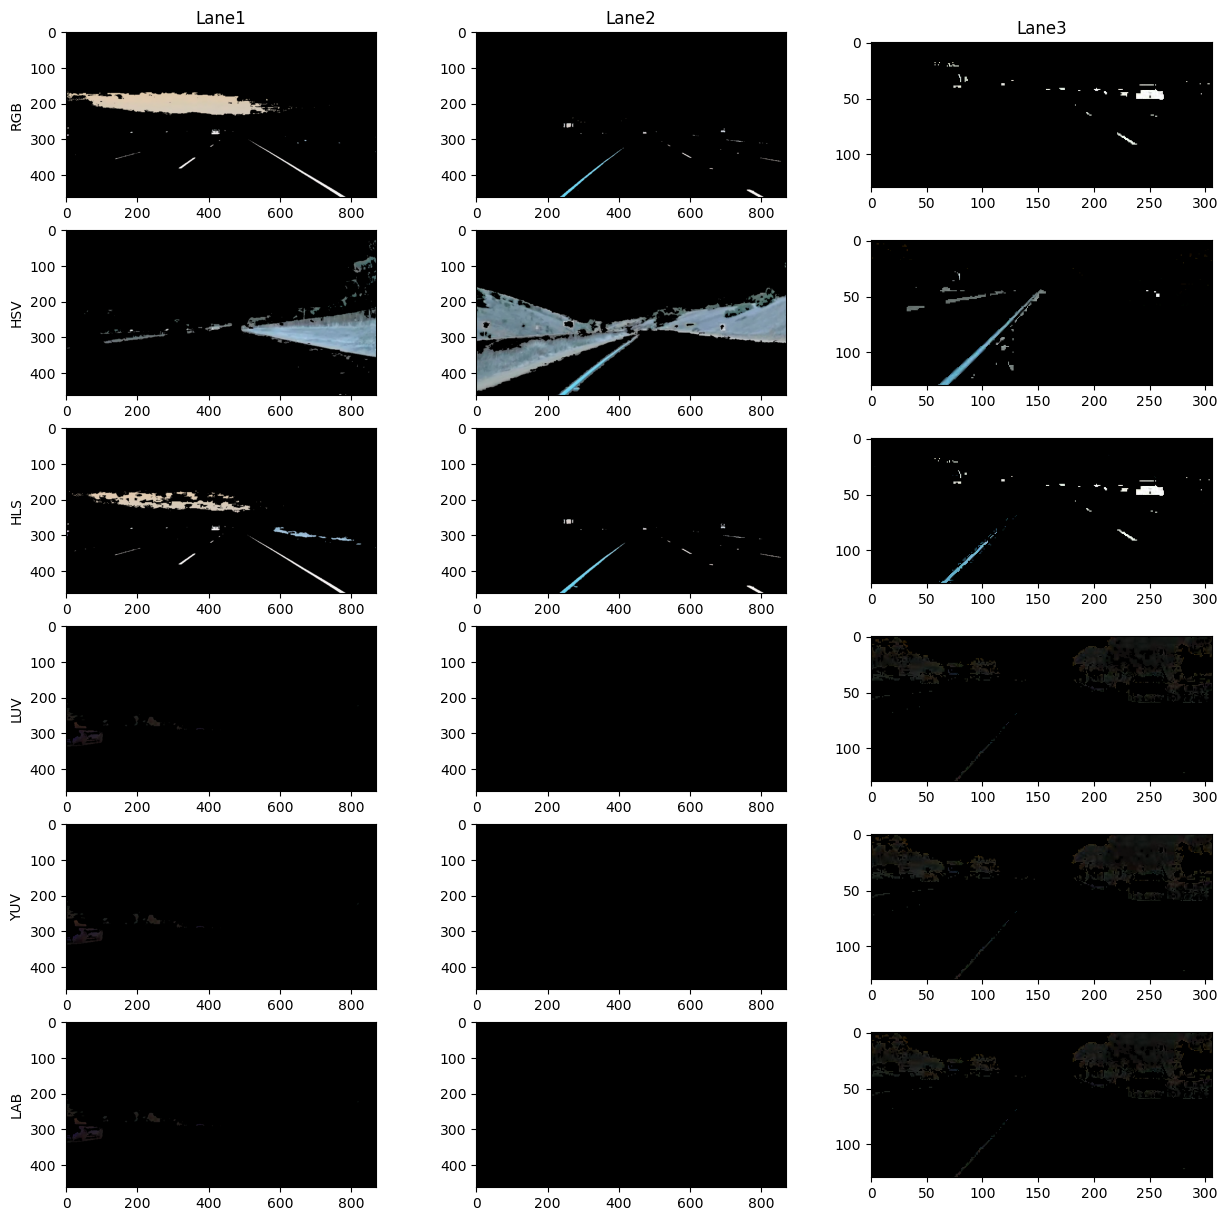

In [3]:
def color_selection(image, colorspace):
    converted_image = cv.cvtColor(image, colorspace)
    
    #White color mask
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv.inRange(converted_image, lower_threshold, upper_threshold)

    mask = cv.bitwise_or(white_mask, yellow_mask)
    masked_image = cv.bitwise_and(image, image, mask = mask)
    
    return masked_image

lane1 = cv.imread('images/ex4/lane1_undistorted.jpeg')
lane2 = cv.imread('images/ex4/lane2_undistorted.jpeg')
lane3 = cv.imread('images/ex4/lane3_undistorted.jpeg')

lane1_RGB = color_selection(lane1, cv.COLOR_BGR2RGB)
lane2_RGB = color_selection(lane2, cv.COLOR_BGR2RGB)
lane3_RGB = color_selection(lane3, cv.COLOR_BGR2RGB)

lane1_HSV = color_selection(lane1, cv.COLOR_BGR2HSV)
lane2_HSV = color_selection(lane2, cv.COLOR_BGR2HSV)
lane3_HSV = color_selection(lane3, cv.COLOR_BGR2HSV)

lane1_HLS = color_selection(lane1, cv.COLOR_BGR2HLS)
lane2_HLS = color_selection(lane2, cv.COLOR_BGR2HLS)
lane3_HLS = color_selection(lane3, cv.COLOR_BGR2HLS)

lane1_LUV = color_selection(lane1, cv.COLOR_BGR2LUV)
lane2_LUV = color_selection(lane2, cv.COLOR_BGR2LUV)
lane3_LUV = color_selection(lane3, cv.COLOR_BGR2LUV)

lane1_YUV = color_selection(lane1, cv.COLOR_BGR2YUV)
lane2_YUV = color_selection(lane2, cv.COLOR_BGR2YUV)
lane3_YUV = color_selection(lane3, cv.COLOR_BGR2YUV)

lane1_LAB = color_selection(lane1, cv.COLOR_BGR2LAB)
lane2_LAB = color_selection(lane2, cv.COLOR_BGR2LAB)
lane3_LAB = color_selection(lane3, cv.COLOR_BGR2LAB)

lanes = [lane1_RGB, lane2_RGB, lane3_RGB, lane1_HSV, lane2_HSV, lane3_HSV, 
         lane1_HLS, lane2_HLS, lane3_HLS, lane1_LUV, lane2_LUV, lane3_LUV, 
         lane1_YUV, lane2_YUV, lane3_YUV, lane1_LAB, lane2_LAB, lane3_LAB ]

_, axs = plt.subplots(6, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax in zip(lanes, axs):
    ax.imshow(img)
    
axs[0].set_ylabel('RGB')
axs[3].set_ylabel('HSV')
axs[6].set_ylabel('HLS')
axs[9].set_ylabel('LUV')
axs[12].set_ylabel('YUV')
axs[15].set_ylabel('LAB')

axs[0].set_title('Lane1')
axs[1].set_title('Lane2')
axs[2].set_title('Lane3')

plt.show()

#### 4.2.2 Canny Edge Detection
We will apply Canny Edge Detection in order to isolate the road lines in each image. Firstly, we convert the image to grayscale and then apply a gaussian blur to eliminate any surrounding noise, then we apply the Canny filter.

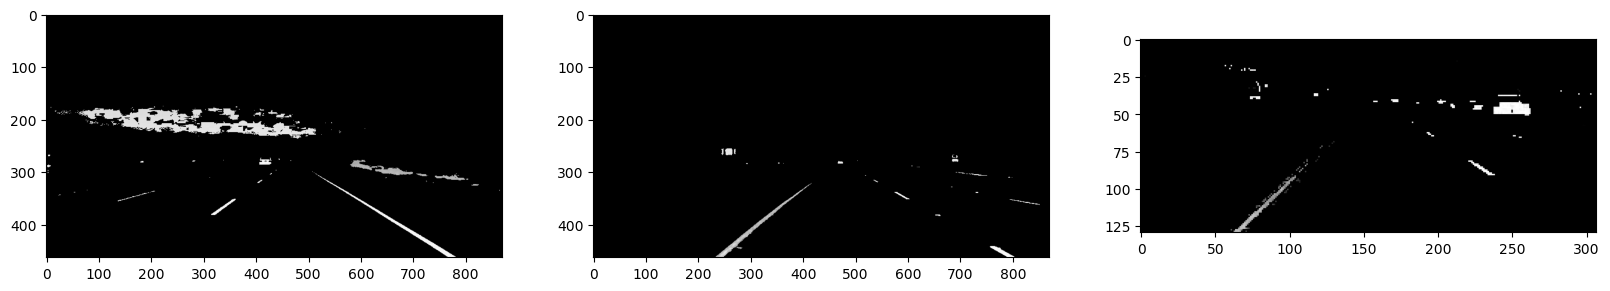

In [4]:
lane1_gray = cv.cvtColor(cv.cvtColor(lane1_HLS, cv.COLOR_HLS2RGB), cv.COLOR_RGB2GRAY)
lane2_gray = cv.cvtColor(cv.cvtColor(lane2_HLS, cv.COLOR_HLS2RGB), cv.COLOR_RGB2GRAY)
lane3_gray = cv.cvtColor(cv.cvtColor(lane3_HLS, cv.COLOR_HLS2RGB), cv.COLOR_RGB2GRAY)

_, axs = plt.subplots(1, 3, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip([lane1_gray, lane2_gray, lane3_gray], axs):
    ax.imshow(img, cmap="gray", vmin=0, vmax=255)

plt.show()

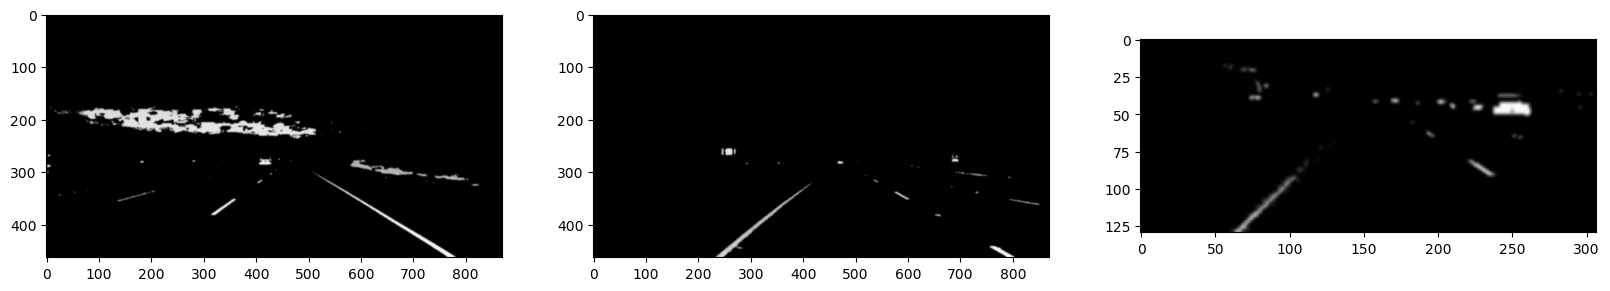

In [5]:
lane1_gaussian = cv.GaussianBlur(lane1_gray, (5, 5), 0)
lane2_gaussian = cv.GaussianBlur(lane2_gray, (5, 5), 0)
lane3_gaussian = cv.GaussianBlur(lane3_gray, (5, 5), 0)

_, axs = plt.subplots(1, 3, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip([lane1_gaussian, lane2_gaussian, lane3_gaussian], axs):
    ax.imshow(img, cmap="gray", vmin=0, vmax=255)

plt.show()

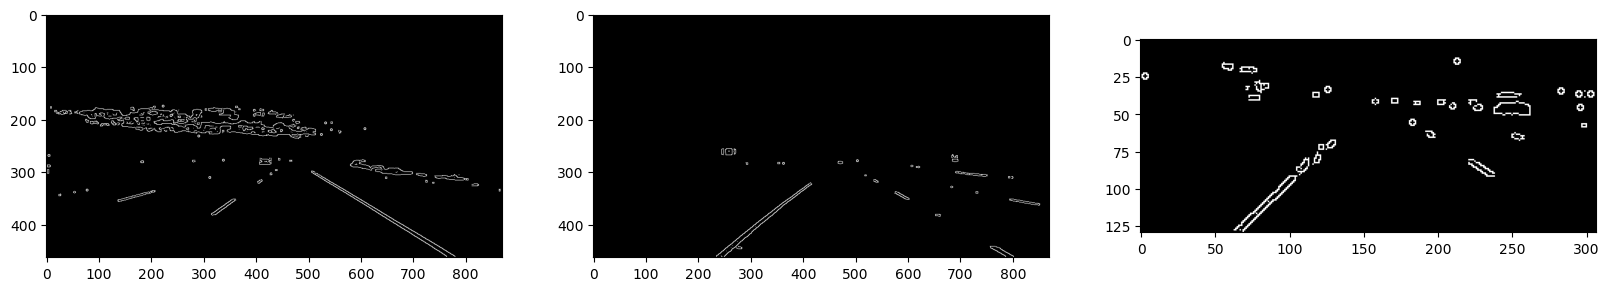

In [6]:
lane1_canny = cv.Canny(lane1_gaussian, 100, 200, apertureSize=7)
lane2_canny = cv.Canny(lane2_gaussian, 100, 200, apertureSize=7)
lane3_canny = cv.Canny(lane3_gaussian, 100, 200, apertureSize=7)

_, axs = plt.subplots(1, 3, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip([lane1_canny, lane2_canny, lane3_canny], axs):
    ax.imshow(img, cmap="gray", vmin=0, vmax=255)

plt.show()

#### 4.2.3 ROI Selection
The Canny Edge Detector computed edges for parts of the image that aren't relevant, so we selected only the parts of the image that correspond to the lanes. We assumed that the images are taken by a dashboard camera in a fixed position, so the lane markers are roughly always the same distance apart. Both lane1 and lane2 were taken with the same camera and with the same conditions, so they also have similar resolution and the thresholds applied to both those images are the same. As for lane3, its resolution is smaller and it was captured in a different position, so the thresholds applied are different.

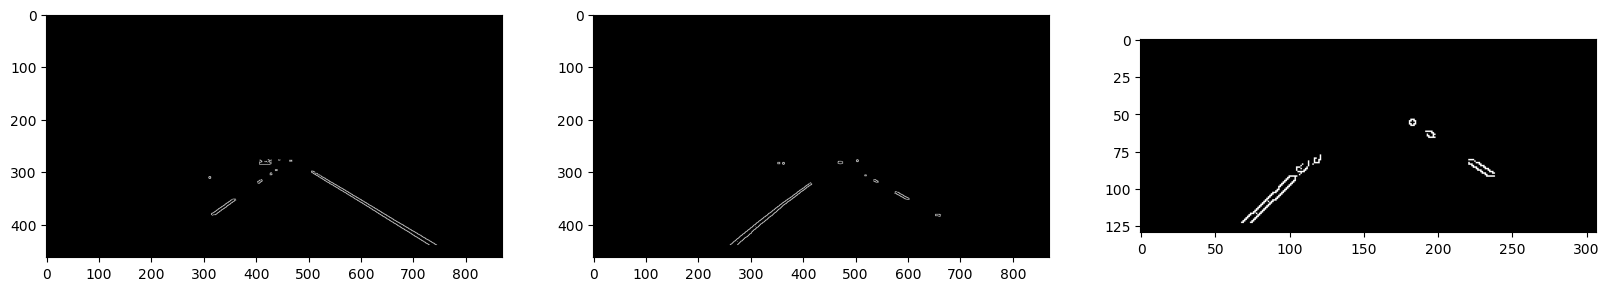

In [7]:
def roi_selection(image, lane3):
    mask = np.zeros_like(image)   

    rows, cols = image.shape[:2]

    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.95, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.4] if lane3 else [cols * 0.6, rows * 0.6]

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv.fillPoly(mask, vertices, 255)

    masked_image = cv.bitwise_and(image, mask)
    return masked_image

lane1_roi = roi_selection(lane1_canny, False)
lane2_roi = roi_selection(lane2_canny, False)
lane3_roi = roi_selection(lane3_canny, True)

_, axs = plt.subplots(1, 3, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip([lane1_roi, lane2_roi, lane3_roi], axs):
    ax.imshow(img, cmap="gray", vmin=0, vmax=255)

plt.show()

#### 4.2.4 Hough Lines
With the region of interest selected, we detect lines using the Hough Transform and overlap it with the original images.

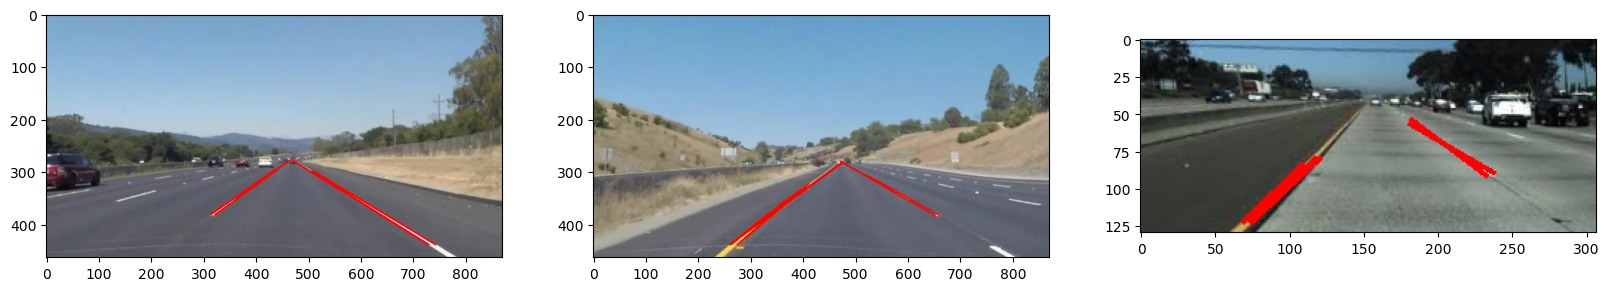

In [8]:
def draw_lines(image, lines):
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv.line(image, (x1, y1), (x2, y2), [255, 0, 0], 2)
    return image

lane1_rgb = cv.cvtColor(lane1, cv.COLOR_BGR2RGB)
lane2_rgb = cv.cvtColor(lane2, cv.COLOR_BGR2RGB)
lane3_rgb = cv.cvtColor(lane3, cv.COLOR_BGR2RGB)

lane1_hough = cv.HoughLinesP(lane1_roi, rho = 1, theta = np.pi/180, threshold = 25, minLineLength = 20, maxLineGap = 300)
lane2_hough = cv.HoughLinesP(lane2_roi, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap = 300)
lane3_hough = cv.HoughLinesP(lane3_roi, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap = 300)

line_images = []
for image, lines in zip([lane1_rgb,lane2_rgb,lane3_rgb], [lane1_hough, lane2_hough, lane3_hough]):
    line_images.append(draw_lines(image, lines))

_, axs = plt.subplots(1, 3, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(line_images, axs):
    ax.imshow(img)

plt.show()

Since we want complete lane markings and only one line per marking, we have to consolidate and extrapolate the Hough Lines gathered before.

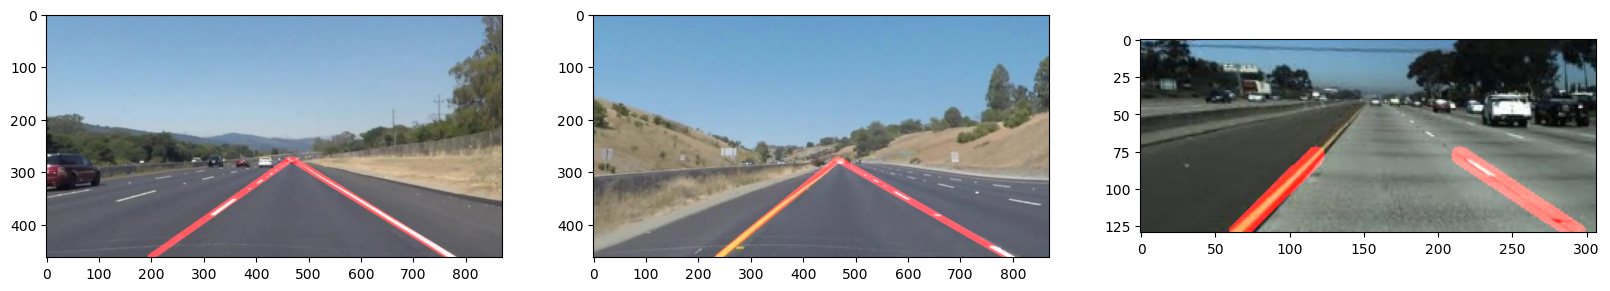

In [12]:
def extrapolate_lines(lines):
    left_lines    = [] 
    left_weights  = [] 
    right_lines   = []
    right_weights = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
                
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    
    return left_lane, right_lane

def points_pixel(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    left_lane, right_lane = extrapolate_lines(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = points_pixel(y1, y2, left_lane)
    right_line = points_pixel(y1, y2, right_lane)
    return left_line, right_line
    
def draw_lane_lines(image, lines):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv.line(line_image, *line, [255, 0, 0], 12)
    return cv.addWeighted(image, 1.0, line_image, 1.0, 0.0)
             
    
lane_images = []
for image, lines in zip([lane1_rgb,lane2_rgb,lane3_rgb], [lane1_hough, lane2_hough, lane3_hough]):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

_, axs = plt.subplots(1, 3, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(lane_images, axs):
    ax.imshow(img)

plt.show()

### 4.3 Perspective Transformation - Birds Eye View
Just like in the ROI selection, the perspective transformation is highly dependendant on the image resolution, so we assumed that images taken in the same conditions (lane1 and lane2) with roughly have the same src and dst points for the transformation. lane3 has a different resolution, so it's points are different. 

We choose to keep the top unchanged while shrinking the bottom, in order to keep the most amount of information from the viewing angle.

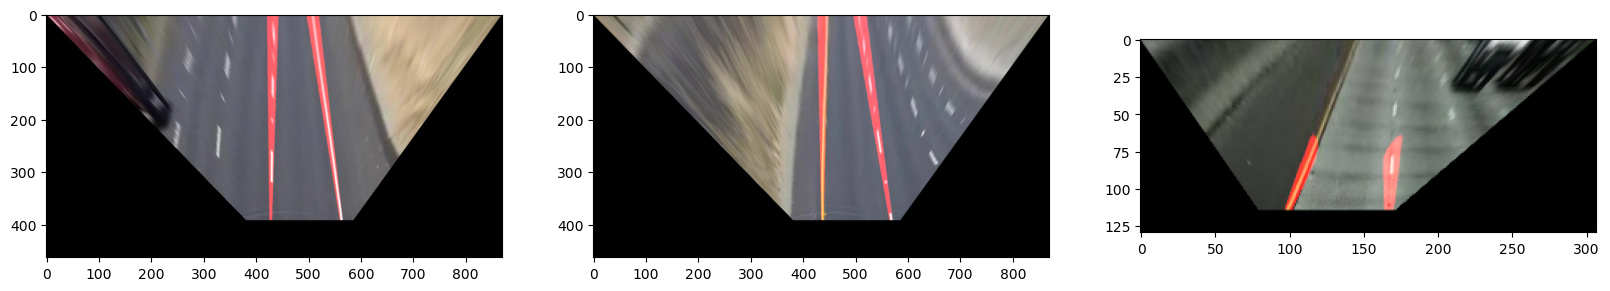

In [11]:
warped_imgs = []

def birds_eye_view(imgs, src, dst, crop):
    for img in imgs:
        IMAGE_H, IMAGE_W = img.shape[:2]

        # Compute the perspective transform matrices
        M = cv.getPerspectiveTransform(src, dst)
        Minv = cv.getPerspectiveTransform(dst, src)

        img = img[crop:(crop+IMAGE_H), 0:IMAGE_W]
        warped_imgs.append(cv.warpPerspective(img, M, (IMAGE_W, IMAGE_H), flags=cv.INTER_LINEAR)) # Image warping

h_1_2, w_1_2 = lane_images[0].shape[:2]
src_1_2 = np.float32([[0, h_1_2], [820, h_1_2], [0, 0], [w_1_2, 0]])
dst_1_2 = np.float32([[450, h_1_2], [530, h_1_2], [0, 0], [w_1_2, 0]])

h_3, w_3 = lane_images[2].shape[:2]
src_3 = np.float32([[0, h_3], [290,  h_3], [0, 0], [w_3, 0]])
dst_3 = np.float32([[90, h_3], [150, h_3], [0, 0], [w_3, 0]])

birds_eye_view(lane_images[:2], src_1_2, dst_1_2, 300)
birds_eye_view([lane_images[2]], src_3, dst_3, 50)
_, axs = plt.subplots(1, 3, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(warped_imgs, axs):
    ax.imshow(img)

plt.show()